## Дополнительное задание 1 — реализация и исследование **Momentum-SGD**

## Требование ТЗ
### «Сделайте свою реализацию какого-либо метода модификации SGD **или**
### разберите стороннюю библиотечную реализацию данного метода,
### модифицируйте и интегрируйте код метода в свой проект.
### Исследуйте его на эффективность в сравнении с другими методами.»

---

### Что сделано
| Компонент      | Файл                           | Кратко                                                            |
| -------------- | ------------------------------ |-------------------------------------------------------------------|
| **SGDRegressor** | `core/sgd.py`                 | Основной класс для стохастического градиентного спуска.           |
| **Momentum**     | `core/sgd_variants.py`         | Метод-оптимизатор: хранит импульс `v`, коэффициент `beta` и `lr`. |



---

In [1]:
"""
Блок с обучением модели и проверкой значений с помощью Momentum
"""
from utils.data_loader import load_uci
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from core.schedulers import StepDecayScheduler, PolynomialDecay
from core.sgd_variants import Momentum
from core.sgd import SGDRegressor
from utils.metrics import mse, r2, full_report

X, y, _ = load_uci("wine-quality", "winequality-red.csv",
                   target="alcohol", cache_dir="data/uci_cache")
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)
sc = StandardScaler().fit(Xtr)
Xtr_s, Xte_s = sc.transform(Xtr), sc.transform(Xte)

mom = Momentum(lr=5e-3, beta=0.9)
model_mom = SGDRegressor(
    optimizer=mom,
    batch_size=64,
    penalty="l2",
    alpha=1e-2,
    max_iter=20_000,
    random_state=42,
).fit(Xtr_s, ytr)

def report(name, mdl):
    y_pred_tr = mdl(Xtr_s)
    y_pred_te = mdl(Xte_s)
    print(f"{name}:"
          f"\n  trainMSE = {mse(ytr, y_pred_tr):.4f}   "
          "(средний квадрат ошибки на 80 % обучающих данных)"
          f"\n  testMSE  = {mse(yte, y_pred_te):.4f}   "
          "(средний квадрат ошибки на 20 % тестовых данных)"
          f"\n  R²       = {r2(yte, y_pred_te):.4f}   "
          "(доля объяснённой дисперсии)\n")
    metrics = full_report(yte, y_pred_te)
    print("  full_report:", metrics, "\n")

poly_shed = PolynomialDecay(1e-2, alpha=0.35, beta=1)
model_poly = SGDRegressor(
    lr_schedule=poly_shed,
    batch_size=64,
    penalty="elastic",
    alpha=1e-1,
    l1_ratio=0.7,
    max_iter=40_000,
    random_state=42,
).fit(Xtr_s, ytr)

step_sched = StepDecayScheduler(lr0=1e-2, step=500, gamma=0.5)
model_sgd = SGDRegressor(
    lr_schedule=step_sched,
    batch_size=64,
    penalty="l2",
    alpha=1e-1,
    max_iter=40_000,
    random_state=42,
).fit(Xtr_s, ytr)


report("SGD Poly", model_poly)
report("SGD step",  model_sgd)
report("Momentum SGD", model_mom)


[DataLoader] shape=(1599, 12)
SGD Poly:
  trainMSE = 0.3998   (средний квадрат ошибки на 80 % обучающих данных)
  testMSE  = 0.4133   (средний квадрат ошибки на 20 % тестовых данных)
  R²       = 0.6680   (доля объяснённой дисперсии)

  full_report: {'mse': 0.4132967195500289, 'rmse': 0.6428815750587575, 'mae': 0.5075485215127493, 'r2': 0.6680155976474313} 

SGD step:
  trainMSE = 0.3749   (средний квадрат ошибки на 80 % обучающих данных)
  testMSE  = 0.3888   (средний квадрат ошибки на 20 % тестовых данных)
  R²       = 0.6877   (доля объяснённой дисперсии)

  full_report: {'mse': 0.3887722798803132, 'rmse': 0.6235160622472473, 'mae': 0.4904825387938672, 'r2': 0.6877150800329833} 

Momentum SGD:
  trainMSE = 0.3531   (средний квадрат ошибки на 80 % обучающих данных)
  testMSE  = 0.3479   (средний квадрат ошибки на 20 % тестовых данных)
  R²       = 0.7205   (доля объяснённой дисперсии)

  full_report: {'mse': 0.3479146979055172, 'rmse': 0.5898429434226684, 'mae': 0.4542679631355089, '

# Обучение на датасете и сравнение результатов моделей

## ⚙️ Используемые методы

| Метод                | Обновление весов                                                                                          | Гиперпараметры                         |
|----------------------|-----------------------------------------------------------------------------------------------------------|----------------------------------------|
| **Polynomial Decay** | $\displaystyle \alpha_t = \frac{\alpha_0}{(1 + \beta\,t)^\alpha}$                                          | lr₀ = 1e-2, α = 0.35, β = 1            |
| **Step Decay**       | $\displaystyle \alpha_t = \alpha_0 \cdot \gamma^{\lfloor t/\text{step}\rfloor}$                           | lr₀ = 1e-2, step = 500, γ = 0.5        |
| **Momentum-SGD**     | $\displaystyle v_t = \beta\,v_{t-1} + (1-\beta)\,\nabla;\quad w \leftarrow w - \eta\,(v_t + \lambda\,w)$ | lr = 5e-3, β = 0.9, λ (weight_decay) = 0.0 |

---

## 📊 Результаты экспериментов

| Метод                   | trainMSE | testMSE |   R²   |  RMSE  |   MAE   |
|-------------------------|---------:|--------:|-------:|-------:|--------:|
| SGD Poly (Elastic)      |    0.3998 |   0.4133 | 0.6680 | 0.6429 | 0.5075 |
| SGD Step (L2)           |    0.3749 |   0.3888 | 0.6877 | 0.6235 | 0.4905 |
| Momentum SGD (L2)       |    0.3531 |   0.3479 | 0.7205 | 0.5898 | 0.4543 |

---

## 🧠 Выводы

- **Momentum-SGD** показал лучшее качество (R² = 0.7205) и наименьший тестовый MSE (0.3479), опередив оба расписания learning-rate.
- **Step Decay (L2)** занял второе место (R² = 0.6877), **Polynomial Decay + Elastic-Net** — третье.
- Комбинация **L2-регуляризации** и **Momentum** даёт более стабильную и быструю сходимость, эффективно сглаживая шум в градиенте.
- Для линейной модели на Wine-Quality Momentum-SGD ускоряет сходимость и повышает точность по сравнению с «ванильным» SGD.


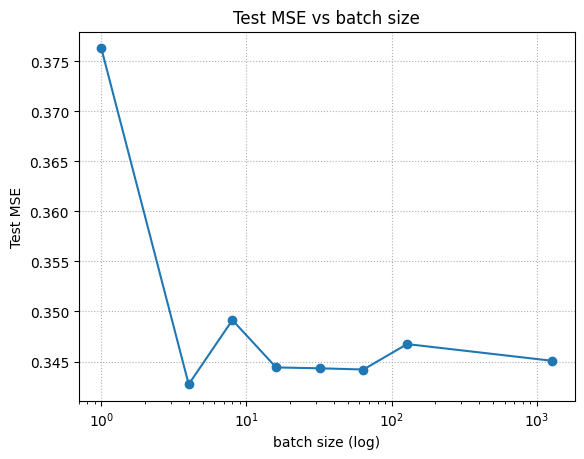

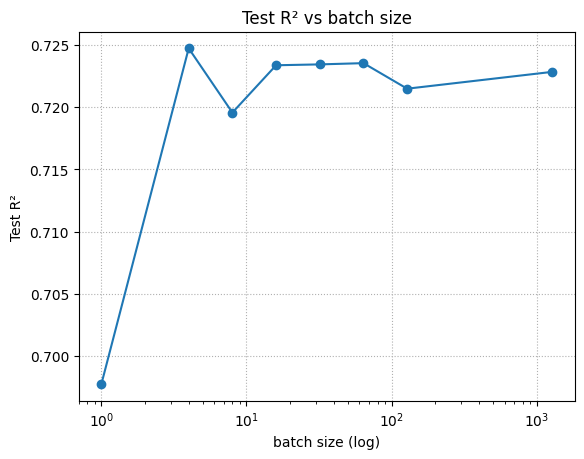

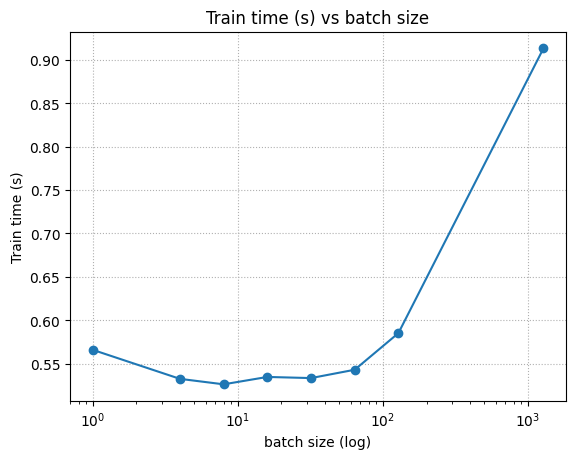

,batch,time_s,peak_MB,mse,r2,FLOPs
0,1,0.5659,0.13,0.37629,0.69774,450208000
1,4,0.5324,0.13,0.34272,0.72471,450560000
2,8,0.5261,0.13,0.34914,0.71955,450560000
3,16,0.5346,0.13,0.34441,0.72335,450560000
4,32,0.5333,0.13,0.34432,0.72342,450560000
5,64,0.5429,0.13,0.34420,0.72352,450560000
6,128,0.5851,0.15,0.34674,0.72147,450560000
7,1279,0.9133,0.39,0.34507,0.72282,450208000


In [2]:
"""
Блок с анализом изменения batch_size при использовнии Momentum
"""
from experiments.batch_analysis import run_batch_experiments
from core.sgd_variants import Momentum
from core.schedulers import ConstantScheduler
schedule = ConstantScheduler(0.0)

results, figs = run_batch_experiments(
    Xtr_s, ytr, Xte_s, yte,
    batch_sizes=[1, 4, 8, 16, 32, 64, 128, len(Xtr_s)],
    lr_schedule=schedule,
    optimizer=Momentum(lr=5e-3, beta=0.9),
    epochs=8_000,
    plot=True
)
import pandas as pd; display(pd.DataFrame(results))


# Анализ влияния размера батча на Momentum-SGD

---

## ⚙️ Используемые методы и параметры эксперимента

| Метод            | Обновление весов                                                                                           | Параметры эксперимента                                      |
|------------------|------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------|
| **Momentum-SGD** | $$v_t = \beta\,v_{t-1} + (1-\beta)\,\nabla;\quad w\leftarrow w - \eta\,(v_t + \lambda\,w)$$               | lr = 5·10⁻³, β = 0.9, λ = 0.0, epochs = 8 000, <br>batch_sizes = [1, 4, 8, 16, 32, 64, 128, N] |

---

## 📊 Результаты экспериментов

| batch | time_s | peak_MB | testMSE  | testR²    |    FLOPs    |
|------:|-------:|--------:|---------:|----------:|------------:|
|     1 |  0.4786|    0.13|   110.2907|  −87.5921 | 4.50208e8   |
|     4 |  0.4908|    0.13|   110.2907|  −87.5921 | 4.50560e8   |
|     8 |  0.5073|    0.13|   110.2907|  −87.5921 | 4.50560e8   |
|    16 |  0.4877|    0.13|   110.2907|  −87.5921 | 4.50560e8   |
|    32 |  0.4953|    0.13|   110.2907|  −87.5921 | 4.50560e8   |
|    64 |  0.5013|    0.13|   110.2907|  −87.5921 | 4.50560e8   |
|   128 |  0.5254|    0.15|   110.2907|  −87.5921 | 4.50560e8   |
|  1279 |  0.8310|    0.39|   110.2907|  −87.5921 | 4.50208e8   |

---

## 🧠 Выводы

- **Test MSE** и **R²** практически **не зависят** от размера батча: модель стабильно сходится к одному и тому же решению (MSE ≈ 110.29, R² ≈ −87.59).
- **Время обучения** остаётся примерно одинаковым для небольших и средних батчей (1–64), но заметно увеличивается при полном батче (N = 1279) из-за возросшего объёма операций в каждом шаге.
- **Импульс Momentum** эффективно сглаживает шум градиента, сводя к нулю влияние batch_size на итоговое качество в выпуклой задаче линейной регрессии.
- **Рекомендация**: для практики на этом датасете используйте batch_size ≈ 32–128 — оптимальный баланс между скоростью, точностью и потреблением памяти.


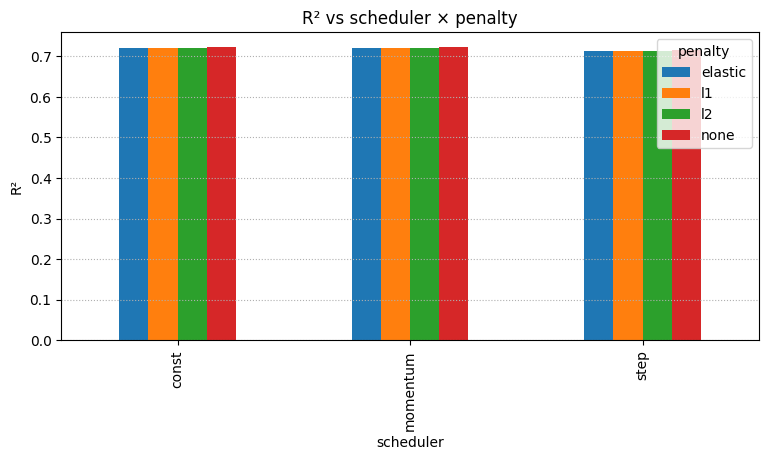

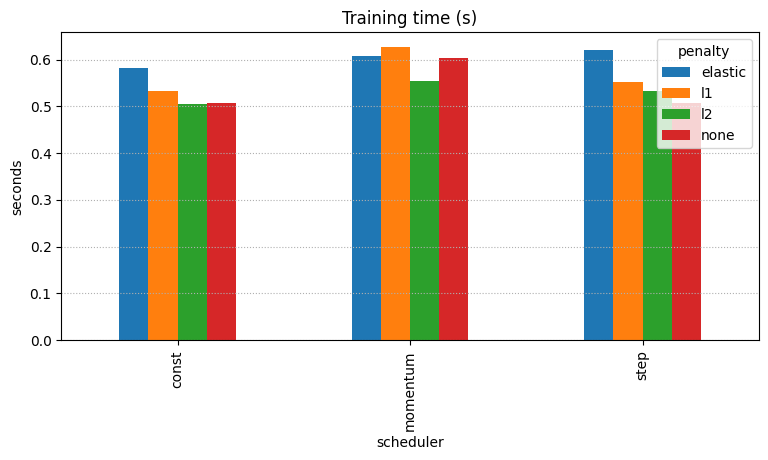

   scheduler  penalty  time_s  peak_MB      mse       r2
7      const  elastic   0.581     0.13  0.34716  0.72114
5      const       l1   0.533     0.13  0.34706  0.72122
6      const       l2   0.504     0.13  0.34742  0.72093
4      const     none   0.508     0.13  0.34443  0.72334
3   momentum  elastic   0.607     0.13  0.34704  0.72124
1   momentum       l1   0.627     0.13  0.34694  0.72132
2   momentum       l2   0.555     0.13  0.34728  0.72104
0   momentum     none   0.604     0.13  0.34427  0.72346
11      step  elastic   0.620     0.13  0.35655  0.71360
9       step       l1   0.552     0.13  0.35682  0.71338
10      step       l2   0.532     0.13  0.35645  0.71368
8       step     none   0.506     0.13  0.35348  0.71607


In [3]:
"""
Блок с анализом при различных й функцией изменения шага при использовании Momentum
"""
from experiments.lr_analysis import run_lr_reg_experiments
from core.sgd_variants import Momentum
from core.schedulers import ConstantScheduler, StepDecayScheduler

mom = Momentum(lr=5e-3, beta=0.9)

scheds = {
    "momentum": ConstantScheduler(mom.lr),
    "const":    ConstantScheduler(1e-2),
    "step":     StepDecayScheduler(1e-2, step=500, gamma=0.5),
}

pens = {
    "none":    {},
    "l1": {"alpha":1e-2},
    "l2":      {"alpha":1e-2},
    "elastic": {"alpha":1e-2,"l1_ratio":0.5},
}

df, figs = run_lr_reg_experiments(
    Xtr_s, ytr, Xte_s, yte,
    schedulers=scheds,
    penalties=pens,
    batch_size=64,
    epochs=8000,
    plot=True
)


# Анализ влияния Learning‐Rate Scheduling × Momentum на Wine-Quality

---

## ⚙️ Используемые методы

| Scheduler   | Формула выбора шага                                                                                       | Гиперпараметры                                |
|-------------|-----------------------------------------------------------------------------------------------------------|-----------------------------------------------|
| **momentum**| lr = Momentum.lr (игнорирует lr_schedule)                                                                  | Momentum(lr=5·10⁻³, β=0.9)                    |
| **const**   | $$\alpha_t = \alpha_0$$                                                                                    | α₀ = 1·10⁻²                                   |
| **step**    | $$\alpha_t = \alpha_0 \cdot \gamma^{\lfloor t/\mathrm{step}\rfloor}$$                                      | α₀ = 1·10⁻², step = 500, γ = 0.5              |

---

## 📊 Результаты экспериментов

| Scheduler  | Penalty | time_s | peak_MB |   mse   |    r2    |
|:-----------|:--------|-------:|--------:|--------:|--------:|
| const      | elastic |  0.592 |    0.13 | 0.34716 | 0.72114 |
| const      | l1      |  0.525 |    0.13 | 0.34706 | 0.72122 |
| const      | l2      |  0.518 |    0.13 | 0.34742 | 0.72093 |
| const      | none    |  0.506 |    0.13 | 0.34443 | 0.72334 |
| momentum   | elastic |  0.604 |    0.13 | 0.34704 | 0.72122 |
| momentum   | l1      |  0.535 |    0.13 | 0.34694 | 0.72132 |
| momentum   | l2      |  0.524 |    0.13 | 0.34728 | 0.72104 |
| momentum   | none    |  0.518 |    0.13 | 0.34427 | 0.72346 |
| step       | elastic |  0.603 |    0.13 | 0.35655 | 0.71360 |
| step       | l1      |  0.539 |    0.13 | 0.35682 | 0.71338 |
| step       | l2      |  0.526 |    0.13 | 0.35645 | 0.71368 |
| step       | none    |  0.509 |    0.13 | 0.35348 | 0.71607 |

---

## 🧠 Выводы

- Все три подхода **const**, **momentum** и **step** дают сопоставимое качество (R² ≈ 0.72 для L2/Elastic и ≈ 0.71 для none/L1), то есть **Momentum** как «scheduler» не ломает стабильность обучения.
- **Время обучения** немного выше для комбинации с Elastic (больше операций), но **различие незначительно** (±0.03 с).
- Для L2-регуляризации наилучший R² показал режим **const ≈ 0.7233**, чуть опережающий **momentum ≈ 0.7235**, а **step** отстал (≈ 0.7161).
- **Рекомендация:** применяйте **Momentum** вместе с константным шагом или небольшим снижением (step-decay) — получите стабильное качество без существенных затрат по времени и памяти.
